import findspark

findspark.init()

# 引入处理数据集需要的相关库和库的依赖 vehicless
import pyspark
from pyspark.sql import SparkSession

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',None)

spark = SparkSession.Builder().appName('VH').getOrCreate()
df = spark.read.csv(inputFile)

topvehicless = df.show()
print(topvehicless)

print(colored("2. filter out now span data:", "blue", attrs=["reverse", "blink"]))
print('schema:')
print(df.printSchema())

In [154]:
from warnings import filterwarnings

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy import stats
import branca.colormap as cm
import researchpy
from dython import nominal
from scipy.stats import shapiro,kstest
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.metrics import mean_squared_error
from feature_engine.categorical_encoders import RareLabelCategoricalEncoder,OrdinalCategoricalEncoder,OneHotCategoricalEncoder
from tpot import TPOTRegressor
from statsmodels.tools.eval_measures import mse,rmse
from sklearn.metrics import r2_score,mean_squared_error
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor
from sklearn.experimental import enable_hist_gradient_boosting  
from sklearn.ensemble import HistGradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score,KFold
from xgboost import plot_importance
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence

You should consider upgrading via the '/home/abel/.virtualenvs/samaritan0/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/abel/.virtualenvs/samaritan0/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/abel/.virtualenvs/samaritan0/bin/python -m pip install --upgrade pip' command.


# 开始数据读取

In [155]:
data=pd.read_csv("/home/abel/AbelExplore/archive/vehicles.csv", nrows=1999)
df=data.copy()
df.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


In [156]:
df=df.drop(columns=["id","url","region_url","image_url","description","VIN","county"],axis=1)
df.head()



,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,lat,long,posting_date
0,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


In [157]:
df.isnull().sum().to_frame()

,0
region,0
price,0
year,49
manufacturer,170
model,40
condition,877
cylinders,741
fuel,61
odometer,39
title_status,130


In [158]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,1999.0,563068.539770,2.220151e+07,0.0000,5500.000000,17200.000000,29984.000000,9.876543e+08
year,1950.0,2011.192821,9.705396e+00,1903.0000,2008.000000,2013.000000,2017.000000,2.021000e+03
odometer,1960.0,204081.291837,9.920668e+05,0.0000,29716.500000,88000.000000,157305.000000,9.999999e+06
lat,1960.0,33.739378,2.165406e+00,26.0218,32.922900,33.455361,33.736853,4.412020e+01
long,1960.0,-85.552447,3.376008e+00,-122.6930,-86.817617,-86.737847,-85.480000,-7.357230e+01


In [159]:
df.describe(include=["object"]).T

,count,unique,top,freq
region,1999,15,birmingham,1647
manufacturer,1829,37,ford,387
model,1959,861,f-150,29
condition,1122,5,good,704
cylinders,1258,8,6 cylinders,537
fuel,1938,5,gas,1614
title_status,1869,5,clean,1824
transmission,1971,3,automatic,1440
drive,1363,3,fwd,507
size,493,4,full-size,358


计算据据缺失率


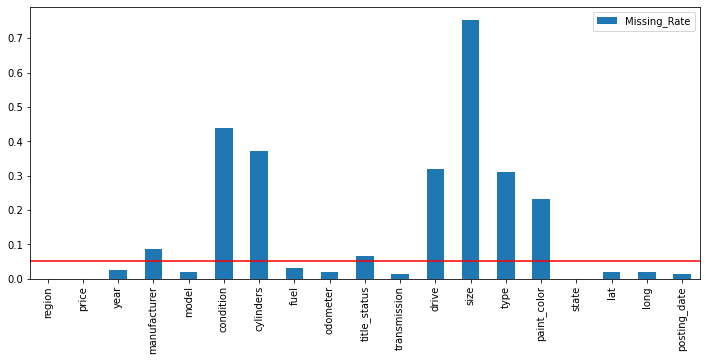

In [160]:
print("计算据据缺失率")
pd.DataFrame(df.isnull().sum()/len(df),columns=["Missing_Rate"]).plot.bar(figsize=(12,5));
plt.axhline(0.05,color="red");

In [161]:
df.dropna().shape

(386, 19)

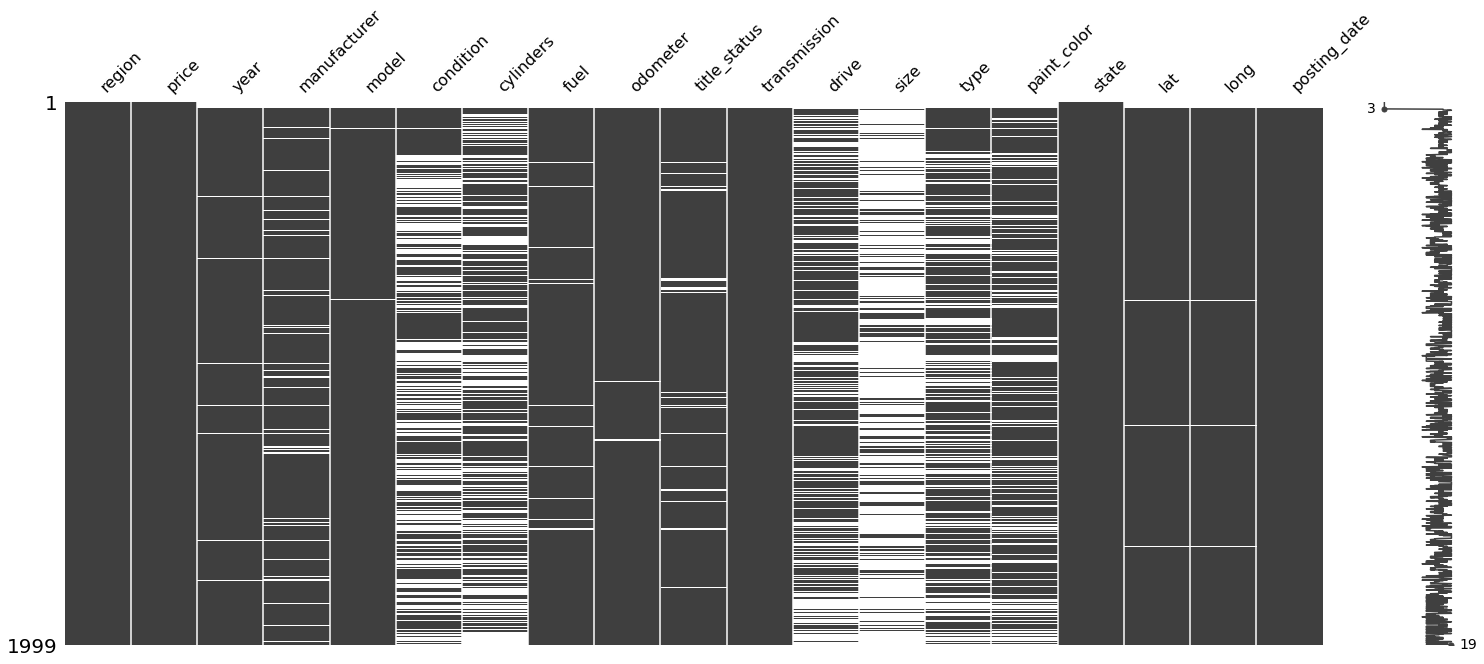

In [162]:
msno.matrix(df);

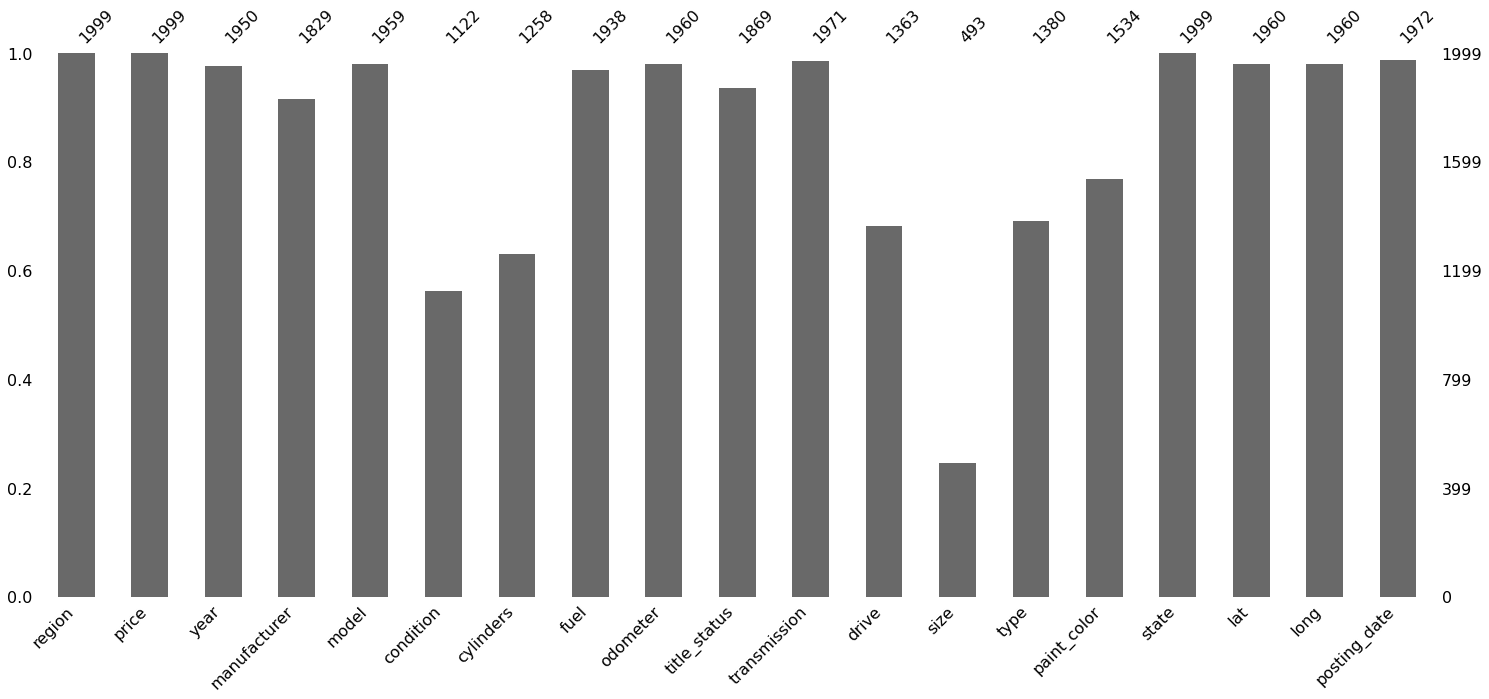

In [163]:
msno.bar(df);

特征热力图分析


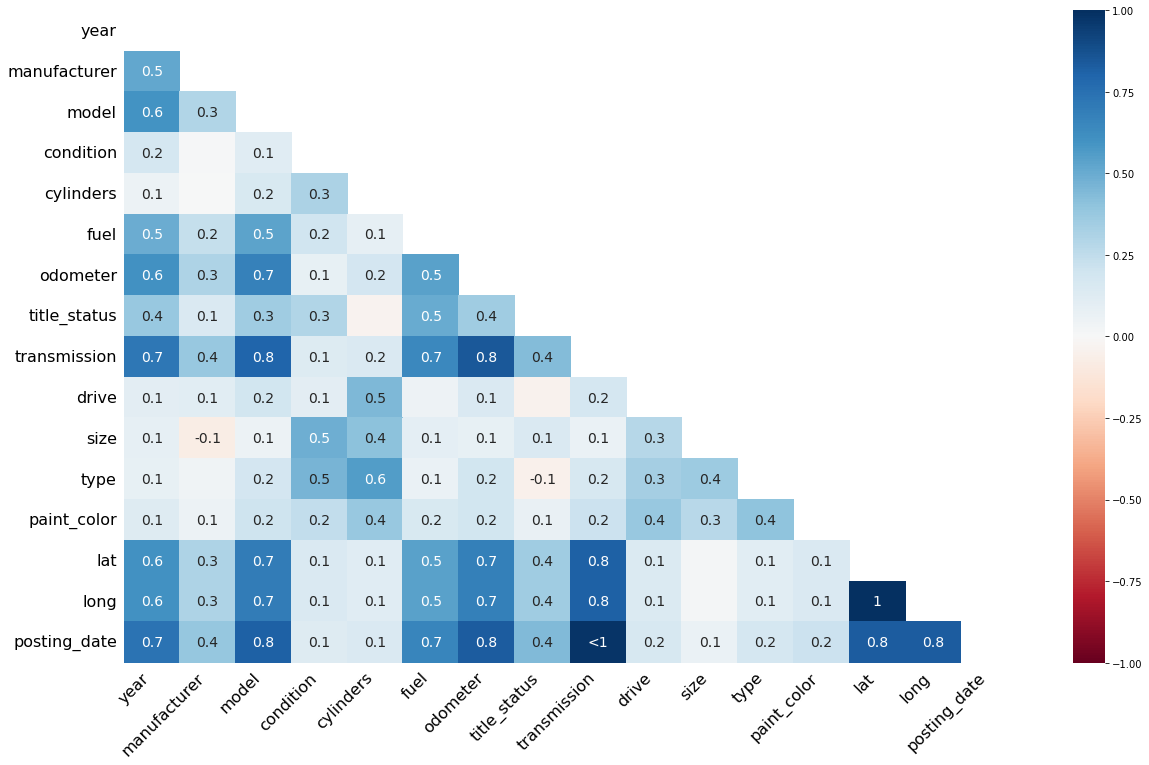

In [164]:
print("特征热力图分析")
msno.heatmap(df);

In [165]:
# H0 : eksik değerlerin ortaya çıkması X özniteliğinin içerdiği farklı değerlerle dağılımı rastgeledir
# H1 : eksik değerlerin ortaya çıkması X özniteliğinin içerdiği farklı değerlerle dağılımı rastgele değildir
testKolon="manufacturer"
for column in df.select_dtypes(include=["object"]).columns :

        crosstab = pd.crosstab(df[column], df[testKolon])
        
        chi_square_value,pval,degrees_of_freedom,table=stats.chi2_contingency(crosstab)  
        print(column,testKolon)
        print('chi_square_value : ',chi_square_value,'\np value : ',pval)
        print('degrees of freedom : ',degrees_of_freedom,'\n')
        
        if pval <0.05:
            print("H0 rejected\n")
        else:
            print("H0 accepted\n")
        
      
    # Actually I applied this to learn how to do chi2 test for missing values.

region manufacturer
chi_square_value :  200.99756843094576 
p value :  3.9616764225472023e-14
degrees of freedom :  72 

H0 rejected

manufacturer manufacturer
chi_square_value :  65844.0 
p value :  0.0
degrees of freedom :  1296 

H0 rejected

model manufacturer
chi_square_value :  65376.0 
p value :  0.0
degrees of freedom :  28008 

H0 rejected

condition manufacturer
chi_square_value :  274.49987565144517 
p value :  2.1368660632633964e-11
degrees of freedom :  136 

H0 rejected

cylinders manufacturer
chi_square_value :  1508.303630663133 
p value :  5.168759544576292e-213
degrees of freedom :  170 

H0 rejected

fuel manufacturer
chi_square_value :  1894.9787553672727 
p value :  8.943236510188242e-303
degrees of freedom :  144 

H0 rejected

title_status manufacturer
chi_square_value :  274.6539084365143 
p value :  3.3125043381482373e-10
degrees of freedom :  144 

H0 rejected

transmission manufacturer
chi_square_value :  274.18225251643076 
p value :  2.3430239398485974e-25


In [166]:
df=df.dropna()
df.shape

(386, 19)

In [167]:
df.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,lat,long,posting_date
31,auburn,15000,2013.0,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,full-size,truck,black,al,32.592000,-85.51890,2021-05-03T14:02:03-0500
55,auburn,19900,2004.0,ford,f250 super duty,good,8 cylinders,diesel,88000.0,clean,automatic,4wd,full-size,pickup,blue,al,32.547500,-85.46820,2021-04-29T17:19:18-0500
59,auburn,14000,2012.0,honda,odyssey,excellent,6 cylinders,gas,95000.0,clean,automatic,fwd,full-size,mini-van,silver,al,32.628739,-85.46182,2021-04-27T12:20:01-0500
65,auburn,22500,2001.0,ford,f450,good,8 cylinders,diesel,144700.0,clean,manual,rwd,full-size,truck,white,al,32.630400,-85.40160,2021-04-26T11:15:36-0500
73,auburn,15000,2017.0,dodge,charger rt 4dr sedan,excellent,8 cylinders,gas,90000.0,rebuilt,automatic,rwd,mid-size,sedan,grey,al,32.822400,-85.77040,2021-04-24T18:39:59-0500


In [168]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386 entries, 31 to 1995
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   region        386 non-null    object 
 1   price         386 non-null    int64  
 2   year          386 non-null    float64
 3   manufacturer  386 non-null    object 
 4   model         386 non-null    object 
 5   condition     386 non-null    object 
 6   cylinders     386 non-null    object 
 7   fuel          386 non-null    object 
 8   odometer      386 non-null    float64
 9   title_status  386 non-null    object 
 10  transmission  386 non-null    object 
 11  drive         386 non-null    object 
 12  size          386 non-null    object 
 13  type          386 non-null    object 
 14  paint_color   386 non-null    object 
 15  state         386 non-null    object 
 16  lat           386 non-null    float64
 17  long          386 non-null    float64
 18  posting_date  386 non-null  

In [169]:
df.odometer=df.odometer.astype(int)
df.year=df.year.astype(int)
df.dtypes

region           object
price             int64
year              int64
manufacturer     object
model            object
condition        object
cylinders        object
fuel             object
odometer          int64
title_status     object
transmission     object
drive            object
size             object
type             object
paint_color      object
state            object
lat             float64
long            float64
posting_date     object
dtype: object

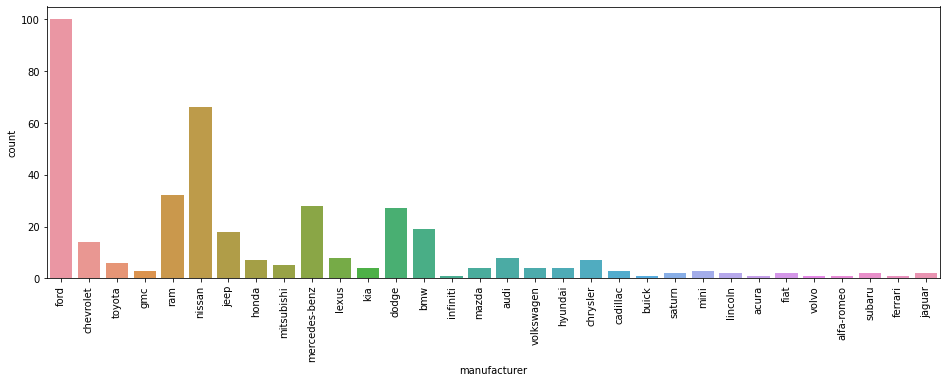

In [170]:
plt.figure(figsize=(16,5));
sns.countplot(df.manufacturer).set_xticklabels(labels=df.manufacturer.value_counts().index ,rotation=90);

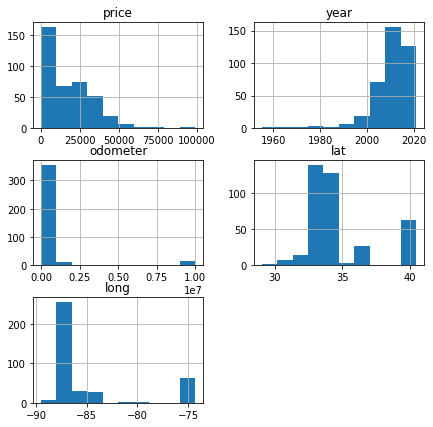

In [171]:
df.hist(figsize=(7,7));

In [172]:
def diagnostic_plots(df, variable):
    
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 3, 1)
    sns.distplot(df[variable], bins=30,kde_kws={'bw': 1.5})
    plt.title('Histogram')
    
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('RM quantiles')

    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    
    
    plt.title('Boxplot')
    
    plt.show()
    
    
to_plot_labels=df.manufacturer.value_counts().nlargest(10).index

-------------------- FORD --------------------
DescribeResult(nobs=100, minmax=(0, 59990), mean=23399.51, variance=199067004.93929294, skewness=0.125786781536706, kurtosis=-0.3653460999926512)


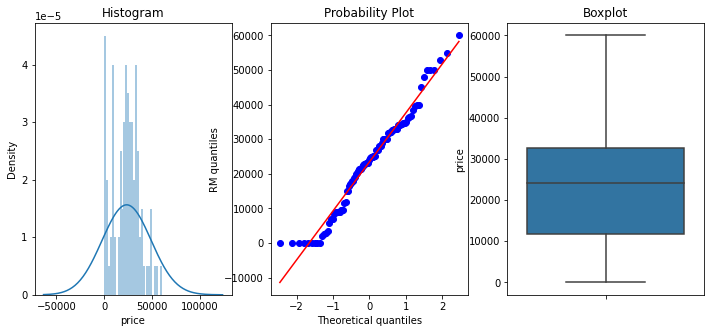

-------------------- CHEVROLET --------------------
DescribeResult(nobs=66, minmax=(0, 72900), mean=17061.363636363636, variance=266753030.41958037, skewness=0.7176583508947008, kurtosis=0.27873575043639987)


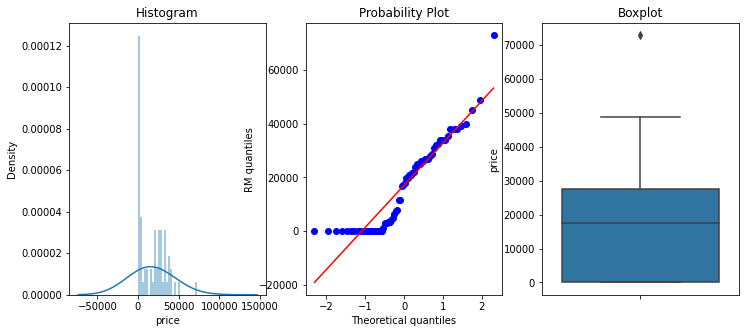

-------------------- TOYOTA --------------------
DescribeResult(nobs=32, minmax=(0, 50000), mean=13559.46875, variance=165970447.22479838, skewness=1.2629645166069972, kurtosis=0.9278843723621595)


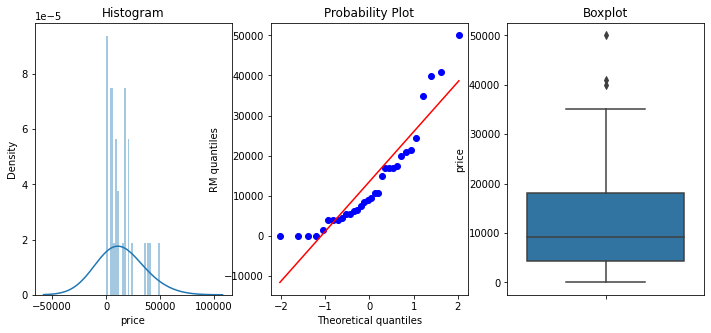

-------------------- GMC --------------------
DescribeResult(nobs=28, minmax=(0, 45950), mean=16654.571428571428, variance=246081904.3280423, skewness=0.30746471051648067, kurtosis=-1.3613142324989491)


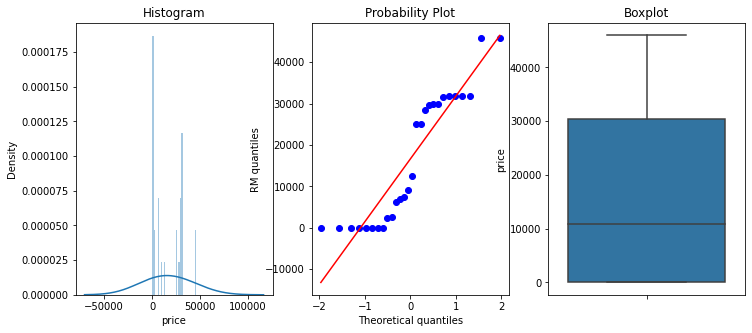

-------------------- RAM --------------------
DescribeResult(nobs=27, minmax=(0, 46990), mean=16516.62962962963, variance=261475029.16524214, skewness=0.4089856919823981, kurtosis=-1.0539398204370793)


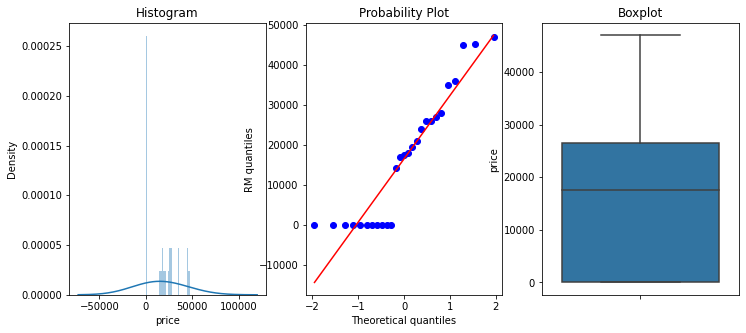

-------------------- NISSAN --------------------
DescribeResult(nobs=19, minmax=(1800, 34900), mean=10435.947368421053, variance=89824200.94152047, skewness=1.1792699232190418, kurtosis=0.5556297148485765)


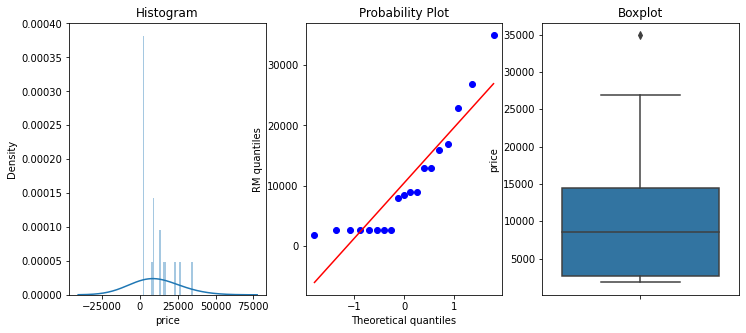

-------------------- JEEP --------------------
DescribeResult(nobs=18, minmax=(0, 40988), mean=19140.11111111111, variance=228020889.9869281, skewness=0.5356434868532698, kurtosis=-1.2596522149677587)


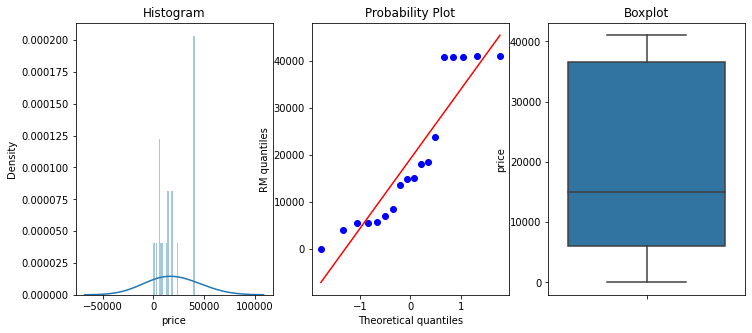

-------------------- HONDA --------------------
DescribeResult(nobs=14, minmax=(2500, 14700), mean=7285.0, variance=20087534.615384616, skewness=0.6189455974148876, kurtosis=-1.2235328258770337)


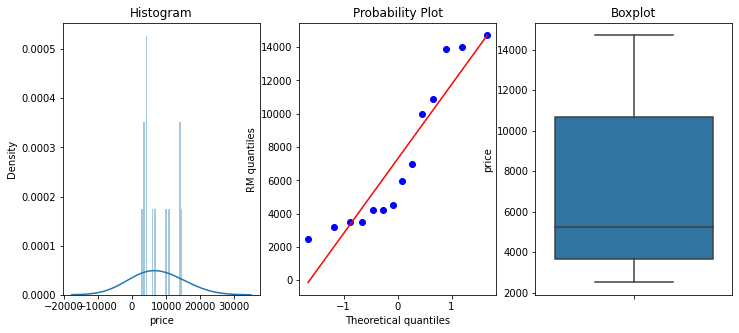

-------------------- MITSUBISHI --------------------
DescribeResult(nobs=8, minmax=(5950, 38990), mean=27047.5, variance=96343592.85714285, skewness=-1.126880797786441, kurtosis=0.9554205352534098)


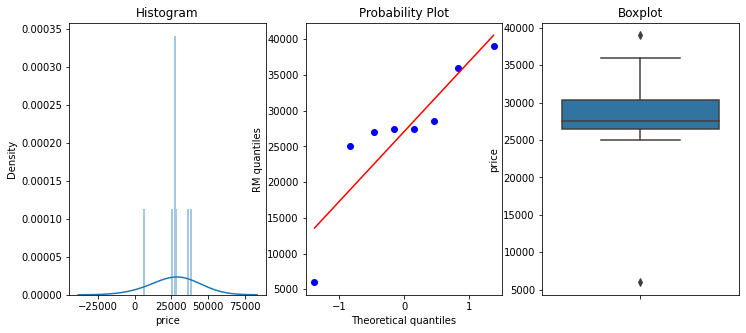

-------------------- MERCEDES-BENZ --------------------
DescribeResult(nobs=8, minmax=(4000, 20888), mean=14419.0, variance=49580812.571428575, skewness=-0.5259313697633273, kurtosis=-1.4600525527214807)


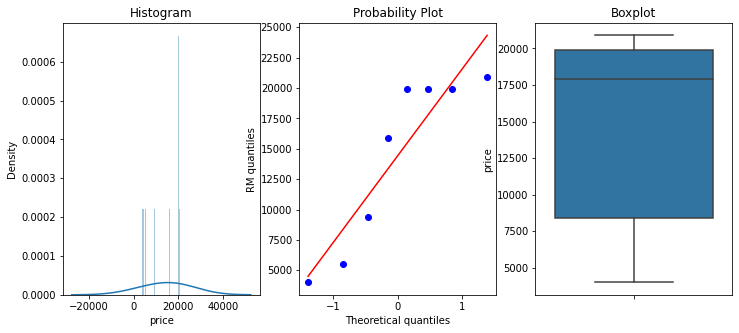

In [173]:
for i in to_plot_labels:
    print("--"*10,str(i).upper(),"--"*10,end="\n")
    print(stats.describe(df[df["manufacturer"]==i]["price"]))
    diagnostic_plots(df[df["manufacturer"]==i],"price")

In [174]:
df.eq(0).sum().to_frame()


,0
region,0
price,53
year,0
manufacturer,0
model,0
condition,0
cylinders,0
fuel,0
odometer,0
title_status,0


In [175]:
df[df.price==0].shape[0]

53

In [176]:
df=df.drop(df[df["price"]==0].index)

In [177]:
stats.describe(df.price)

DescribeResult(nobs=333, minmax=(1, 98900), mean=19752.576576576575, variance=197662462.7087268, skewness=1.0982205427793206, kurtosis=2.4902050918320704)

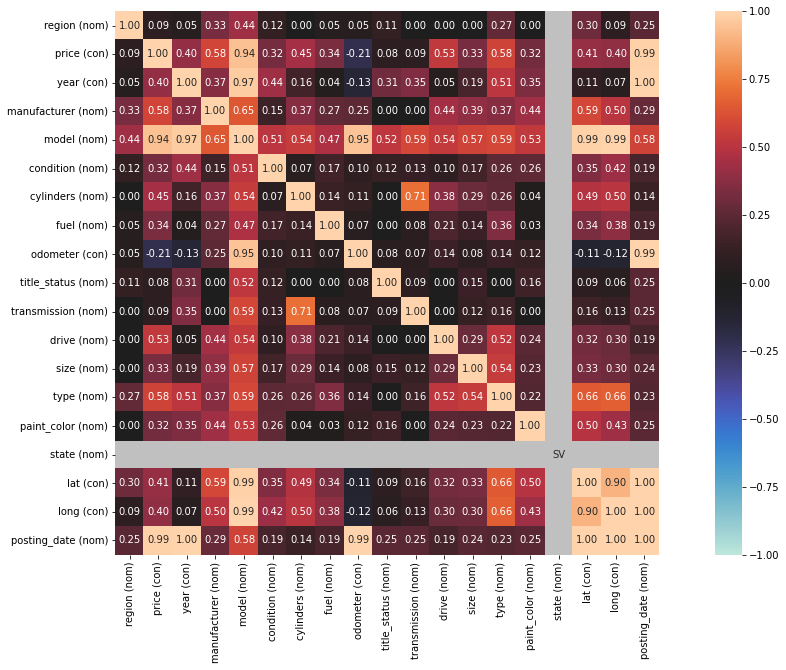

{'corr':                     region (nom)  price (con)  year (con)  manufacturer (nom)  \
 region (nom)            1.000000     0.085443    0.050587            0.331335   
 price (con)             0.085443     1.000000    0.402113            0.582515   
 year (con)              0.050587     0.402113    1.000000            0.368572   
 manufacturer (nom)      0.331335     0.582515    0.368572            1.000000   
 model (nom)             0.435508     0.942147    0.969440            0.646997   
 condition (nom)         0.115279     0.322891    0.435373            0.149326   
 cylinders (nom)         0.000000     0.451204    0.164950            0.369380   
 fuel (nom)              0.049620     0.337502    0.044956            0.267103   
 odometer (con)          0.047544    -0.205218   -0.133815            0.253925   
 title_status (nom)      0.111194     0.081345    0.309308            0.000000   
 transmission (nom)      0.000000     0.092122    0.351981            0.000000   
 drive (

In [178]:
nominal.associations(df,figsize=(20,10),mark_columns=True)

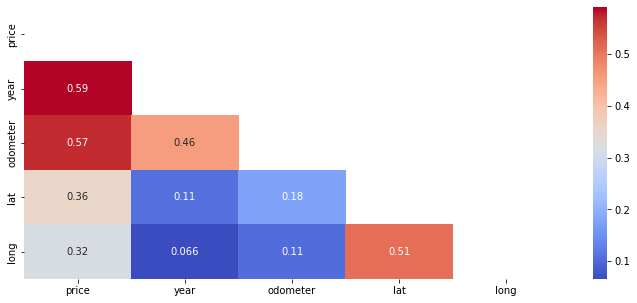

In [179]:
plt.figure(figsize=(12,5))
corr=df.corr(method="spearman").abs()
mask=np.zeros_like(corr,dtype=np.bool)
mask[np.triu_indices_from(mask)]=True
sns.heatmap(corr,annot=True,cmap="coolwarm",mask=mask);

In [180]:
df.drop(df[(df.price<500 )|( df.price>28000)].index)["price"].describe()

count      245.000000
mean     13328.510204
std       7954.205865
min       1200.000000
25%       6895.000000
50%      11500.000000
75%      19950.000000
max      27990.000000
Name: price, dtype: float64

In [181]:
stats.describe(df.drop(df[(df.price<500 )|( df.price>28000)].index)["price"])

DescribeResult(nobs=245, minmax=(1200, 27990), mean=13328.510204081633, variance=63269390.93944464, skewness=0.3038509694786912, kurtosis=-1.2063656153413147)

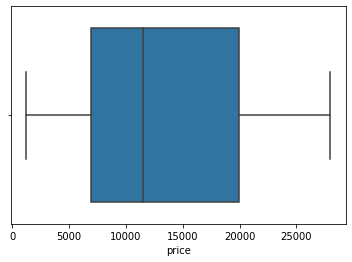

In [182]:
sns.boxplot(df.drop(df[(df.price<500 )|( df.price>28000)].index)["price"]);

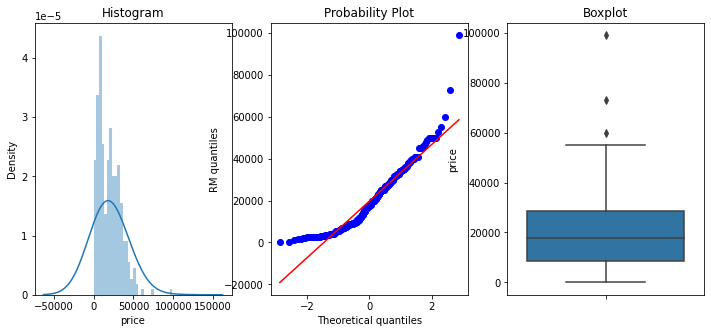

In [183]:
diagnostic_plots(df,"price");

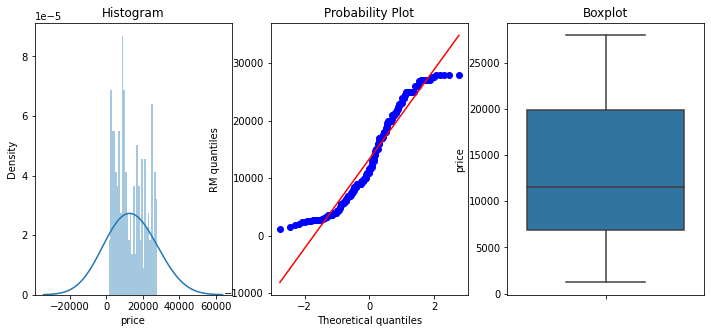

In [184]:
df_cleaned=df.copy()
df_cleaned=df.drop(df[(df.price<500 )|( df.price>28000)].index)
diagnostic_plots(df_cleaned,"price")

Normality Test before boxcox transformation: ShapiroResult(statistic=0.9318365454673767, pvalue=3.2471603184092146e-09)
Normality Test after boxcox transformation: ShapiroResult(statistic=0.9524945020675659, pvalue=3.4476482824175037e-07)


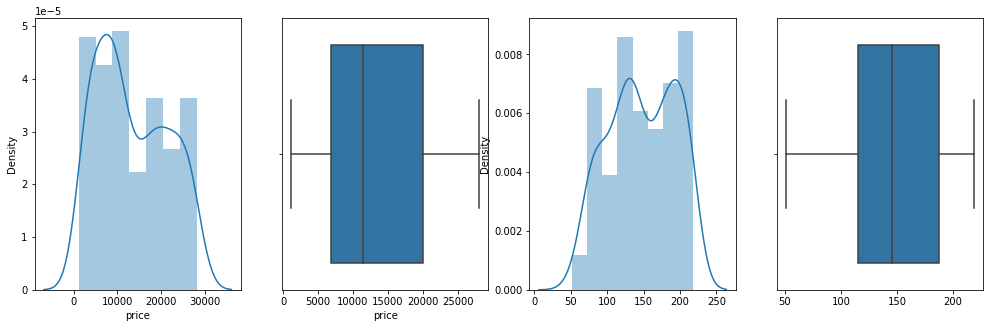

In [185]:
plt.figure(figsize=(17,5))

plt.subplot(141);
sns.distplot(df_cleaned.price);
print("Normality Test before boxcox transformation:",stats.shapiro(df_cleaned.price))

plt.subplot(142);
sns.boxplot(df_cleaned.price);

plt.subplot(143);
sns.distplot(stats.boxcox(df_cleaned.price)[0]);

plt.subplot(144);
sns.boxplot(stats.boxcox(df_cleaned.price)[0]);
print("Normality Test after boxcox transformation:",stats.shapiro(stats.boxcox(df_cleaned.price)[0]))


In [186]:
stats.boxcox(df_cleaned.price)[0][:5]

array([164.55994436, 187.11958292, 159.47469442, 197.84746995,
       164.55994436])

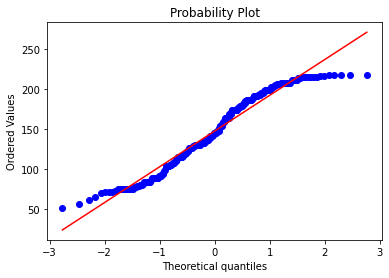

In [187]:
stats.probplot(stats.yeojohnson(df_cleaned.price)[0],dist="norm", plot=plt);

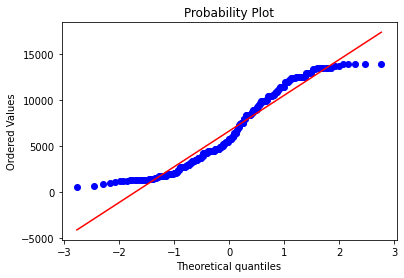

In [188]:
stats.probplot(df_cleaned.price**1/2,dist="norm", plot=plt);

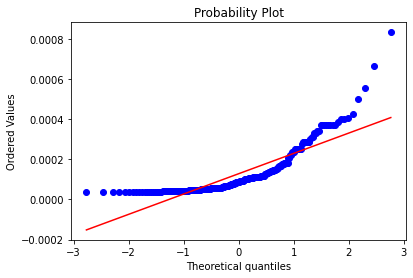

In [189]:
stats.probplot(1/df_cleaned.price,dist="norm", plot=plt);

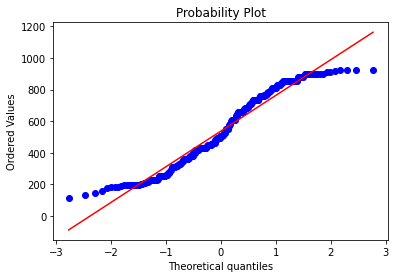

In [190]:
stats.probplot(df_cleaned.price**(1/1.5),dist="norm",plot=plt);

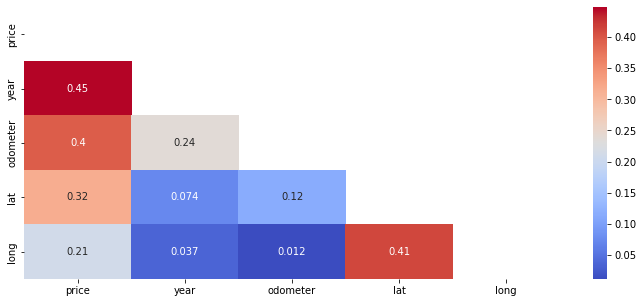

In [191]:
plt.figure(figsize=(12,5))
corr=df_cleaned.corr(method="spearman").abs()
mask=np.zeros_like(corr,dtype=np.bool)
mask[np.triu_indices_from(mask)]=True
sns.heatmap(corr,annot=True,cmap="coolwarm",mask=mask);

In [192]:
researchpy.correlation.corr_pair(df_cleaned.select_dtypes(exclude="object"))

,r value,p-value,N
price & year,0.3121,0.0000,245
price & odometer,-0.0393,0.5400,245
price & lat,0.5296,0.0000,245
price & long,0.4891,0.0000,245
year & odometer,0.0513,0.4244,245
year & lat,0.0630,0.3257,245
year & long,0.0636,0.3214,245
odometer & lat,-0.0727,0.2567,245
odometer & long,-0.1040,0.1045,245
lat & long,0.9191,0.0000,245


In [193]:
df_cleaned.select_dtypes(include="object").columns[1:]

Index(['manufacturer', 'model', 'condition', 'cylinders', 'fuel',
       'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color',
       'state', 'posting_date'],
      dtype='object')

In [194]:
#.associations(df_cleaned,figsize=(20,10),mark_columns=True); # for nominal and categorical (Cramer's V)

In [195]:
'''
for i in df_cleaned.select_dtypes(include="object").columns[1:]:
    print(str(i) + " and " + "model")
    
    crosstab, res = researchpy.crosstab(df_cleaned[i], df_cleaned["model"], test= "chi-square")
    print(res);
'''

'\nfor i in df_cleaned.select_dtypes(include="object").columns[1:]:\n    print(str(i) + " and " + "model")\n    \n    crosstab, res = researchpy.crosstab(df_cleaned[i], df_cleaned["model"], test= "chi-square")\n    print(res);\n'

In [196]:
'''
for i in to_plot_labels:
    print("--"*10,str(i).upper(),"--"*10,end="\n")
    print(stats.describe(df_cleaned[df_cleaned["manufacturer"]==i]["price"]))
    diagnostic_plots(df_cleaned[df_cleaned["manufacturer"]==i],"price")
''''''

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-196-e3f44a6ce2da>, line 6)

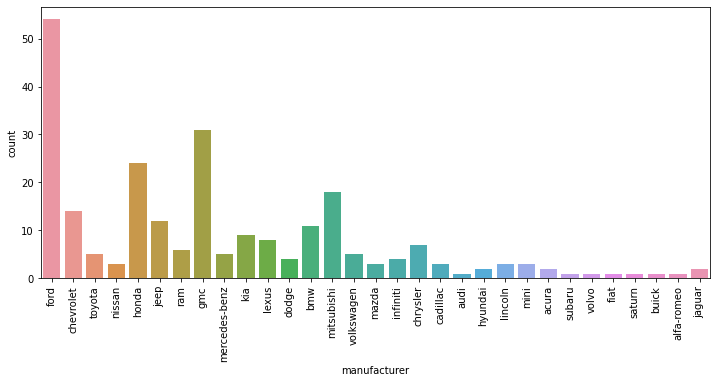

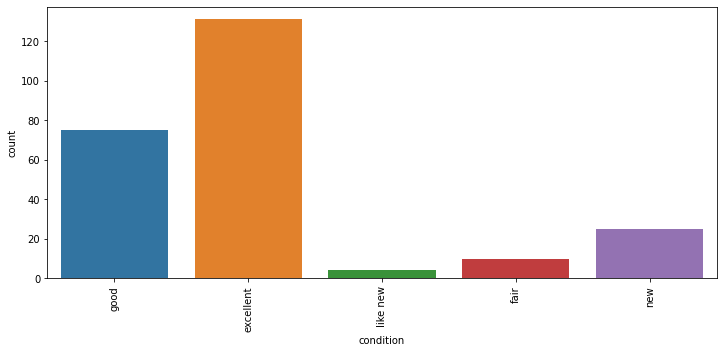

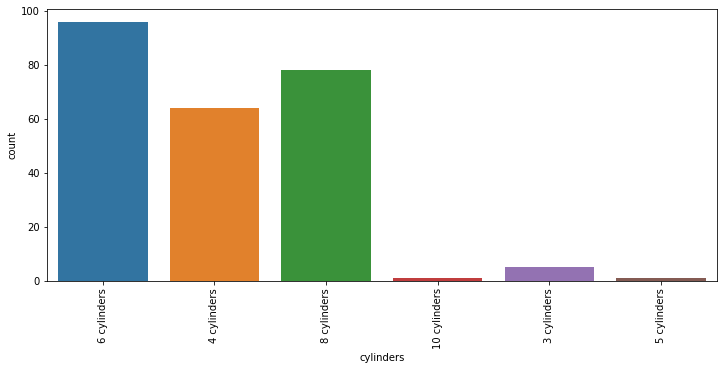

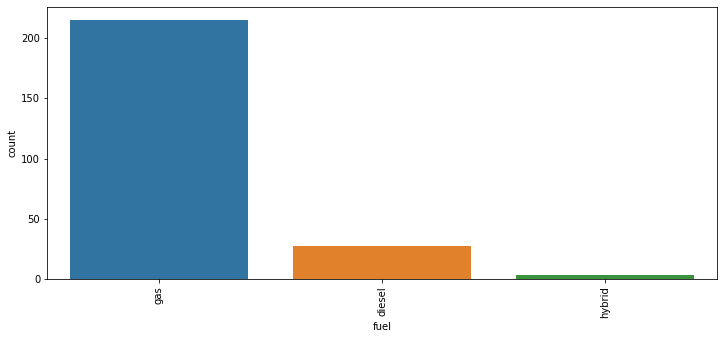

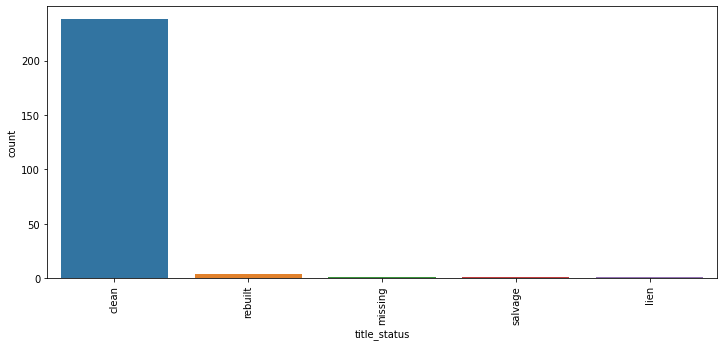

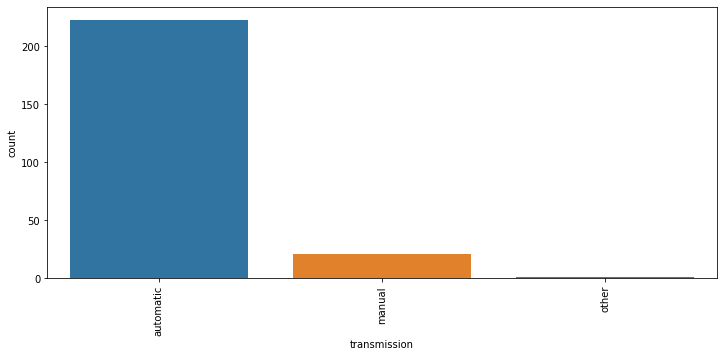

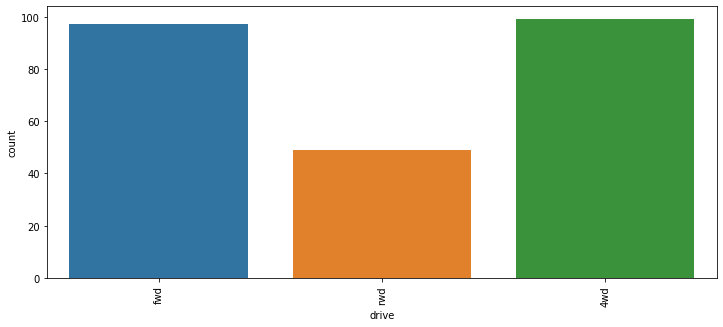

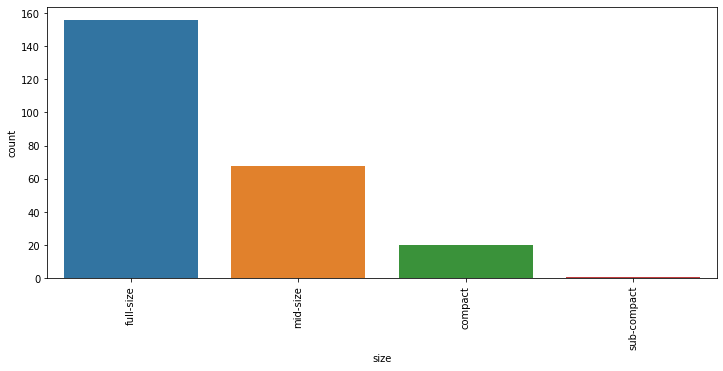

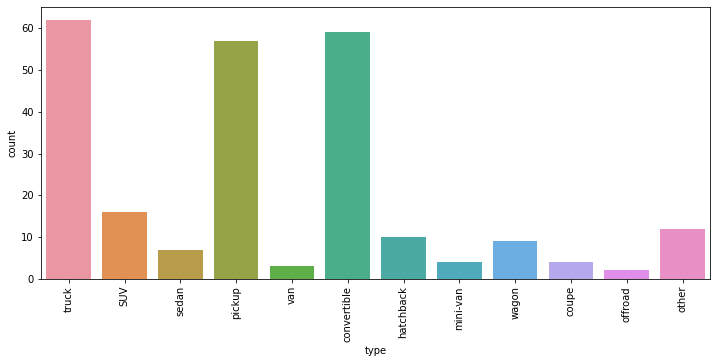

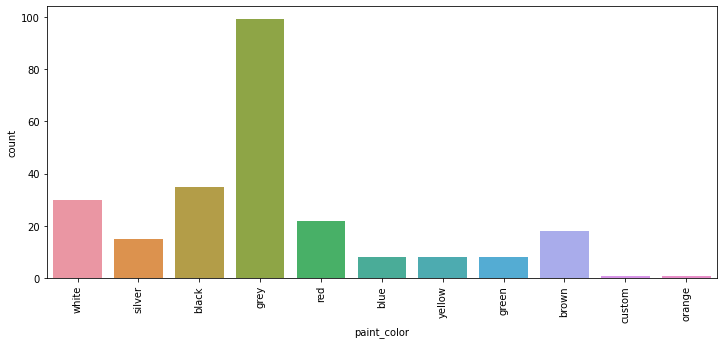

In [197]:
cols=["manufacturer","condition","cylinders","fuel","title_status","transmission","drive","size","type","paint_color"]

for i in cols:
    plt.figure(figsize=(12,5));
    sns.countplot(df_cleaned[i]).set_xticklabels(labels=df_cleaned[i].value_counts().index,rotation=90);
    
    plt.show();

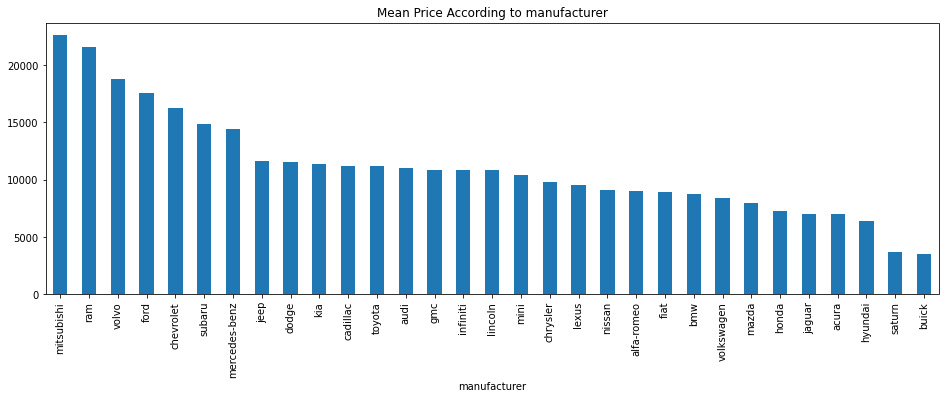

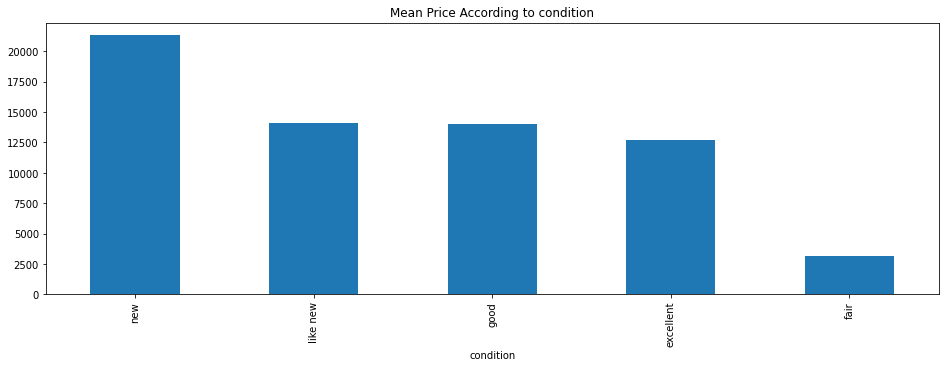

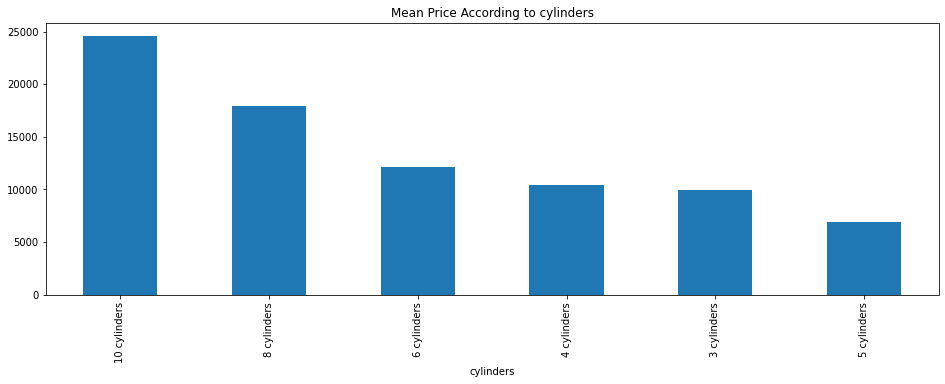

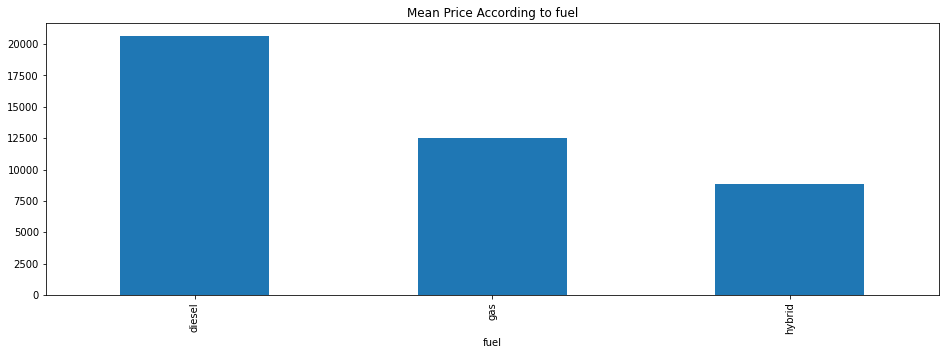

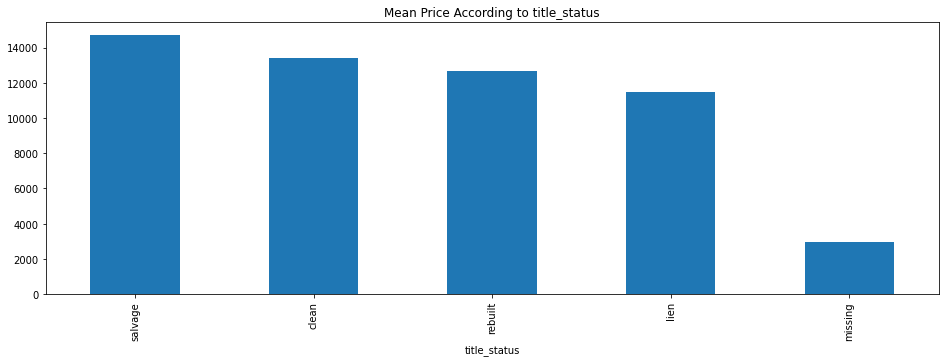

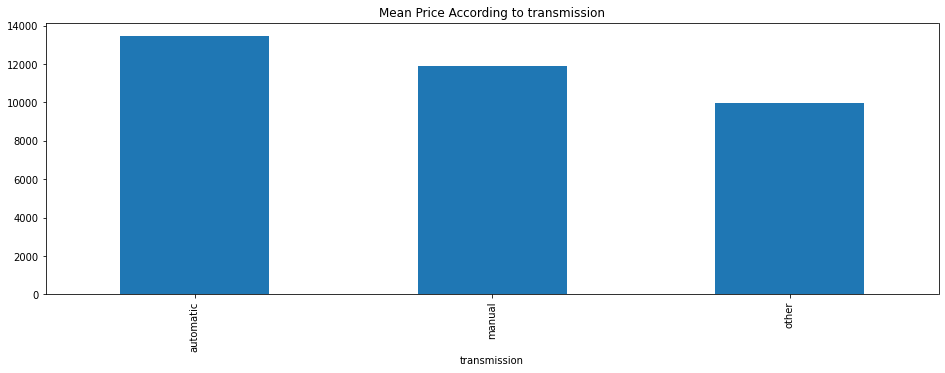

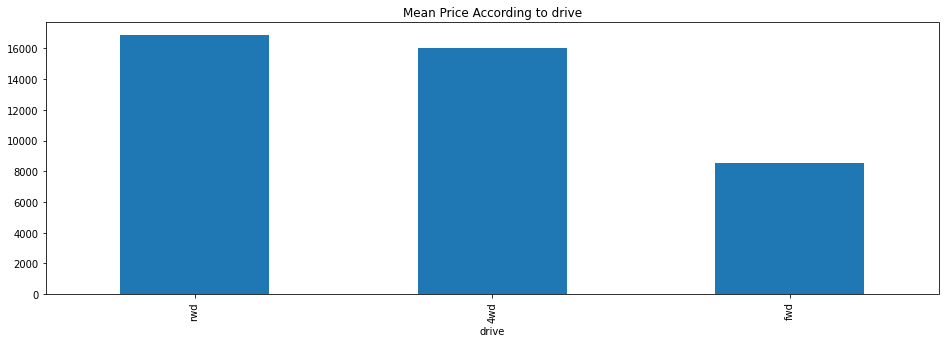

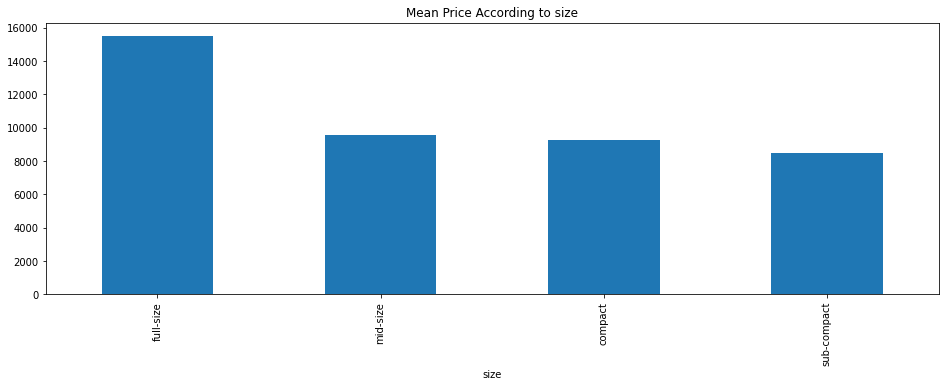

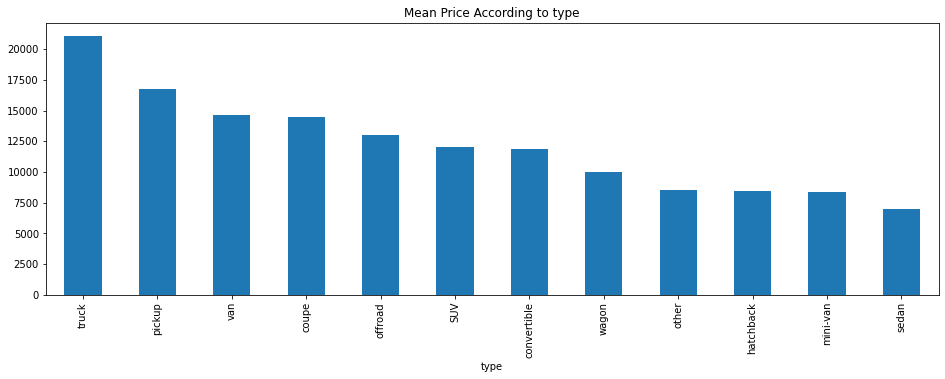

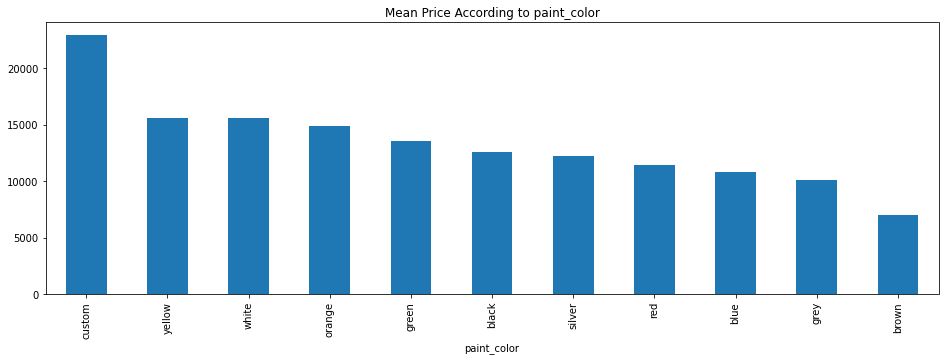

In [198]:

for i in cols:
    df_cleaned.groupby(i)["price"].mean().sort_values(ascending=False).plot.bar(figsize=(16,5));
    plt.title("Mean Price According to " + str(i))
    plt.show();

In [199]:
df_cleaned.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,lat,long,posting_date
31,auburn,15000,2013,ford,f-150 xlt,excellent,6 cylinders,gas,128000,clean,automatic,rwd,full-size,truck,black,al,32.592000,-85.51890,2021-05-03T14:02:03-0500
55,auburn,19900,2004,ford,f250 super duty,good,8 cylinders,diesel,88000,clean,automatic,4wd,full-size,pickup,blue,al,32.547500,-85.46820,2021-04-29T17:19:18-0500
59,auburn,14000,2012,honda,odyssey,excellent,6 cylinders,gas,95000,clean,automatic,fwd,full-size,mini-van,silver,al,32.628739,-85.46182,2021-04-27T12:20:01-0500
65,auburn,22500,2001,ford,f450,good,8 cylinders,diesel,144700,clean,manual,rwd,full-size,truck,white,al,32.630400,-85.40160,2021-04-26T11:15:36-0500
73,auburn,15000,2017,dodge,charger rt 4dr sedan,excellent,8 cylinders,gas,90000,rebuilt,automatic,rwd,mid-size,sedan,grey,al,32.822400,-85.77040,2021-04-24T18:39:59-0500


In [200]:
df_cleaned=df_cleaned.drop(columns=["lat","long","model"],axis=1)
df_cleaned.head()

,region,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,posting_date
31,auburn,15000,2013,ford,excellent,6 cylinders,gas,128000,clean,automatic,rwd,full-size,truck,black,al,2021-05-03T14:02:03-0500
55,auburn,19900,2004,ford,good,8 cylinders,diesel,88000,clean,automatic,4wd,full-size,pickup,blue,al,2021-04-29T17:19:18-0500
59,auburn,14000,2012,honda,excellent,6 cylinders,gas,95000,clean,automatic,fwd,full-size,mini-van,silver,al,2021-04-27T12:20:01-0500
65,auburn,22500,2001,ford,good,8 cylinders,diesel,144700,clean,manual,rwd,full-size,truck,white,al,2021-04-26T11:15:36-0500
73,auburn,15000,2017,dodge,excellent,8 cylinders,gas,90000,rebuilt,automatic,rwd,mid-size,sedan,grey,al,2021-04-24T18:39:59-0500


In [201]:
df_cleaned.state.value_counts().count()

1

In [202]:
df_cleaned.region.value_counts().count()

3

In [203]:
df_cleaned=df_cleaned.drop(columns=["region"],axis=1)

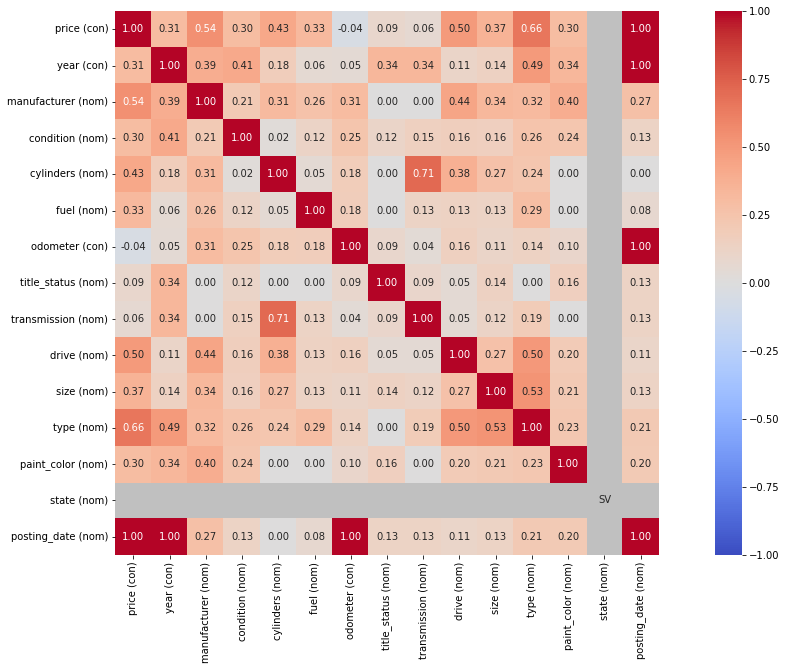

In [204]:
nominal.associations(df_cleaned,figsize=(20,10),mark_columns=True,cmap="coolwarm");

In [205]:
df_cleaned.head()

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,posting_date
31,15000,2013,ford,excellent,6 cylinders,gas,128000,clean,automatic,rwd,full-size,truck,black,al,2021-05-03T14:02:03-0500
55,19900,2004,ford,good,8 cylinders,diesel,88000,clean,automatic,4wd,full-size,pickup,blue,al,2021-04-29T17:19:18-0500
59,14000,2012,honda,excellent,6 cylinders,gas,95000,clean,automatic,fwd,full-size,mini-van,silver,al,2021-04-27T12:20:01-0500
65,22500,2001,ford,good,8 cylinders,diesel,144700,clean,manual,rwd,full-size,truck,white,al,2021-04-26T11:15:36-0500
73,15000,2017,dodge,excellent,8 cylinders,gas,90000,rebuilt,automatic,rwd,mid-size,sedan,grey,al,2021-04-24T18:39:59-0500


In [206]:
def find_skewed_boundaries(df, variable, distance):

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)
    #stats.iqr(df[variable])
    print("IQR Value :",IQR)
    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary



find_skewed_boundaries(df_cleaned,"price",1.5)

IQR Value : 13055.0


(39532.5, -12687.5)

In [207]:
upper_odo,lower_odo=find_skewed_boundaries(df_cleaned,"odometer",1.5)
upper_odo,lower_odo

IQR Value : 85000.0


(300500.0, -39500.0)

In [208]:
df_cleaned[(df_cleaned.odometer>upper_odo)].shape,df_cleaned[~(df_cleaned.odometer>upper_odo)].shape

((3, 15), (242, 15))

In [209]:
df_cleaned[df_cleaned.odometer<0]

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,posting_date


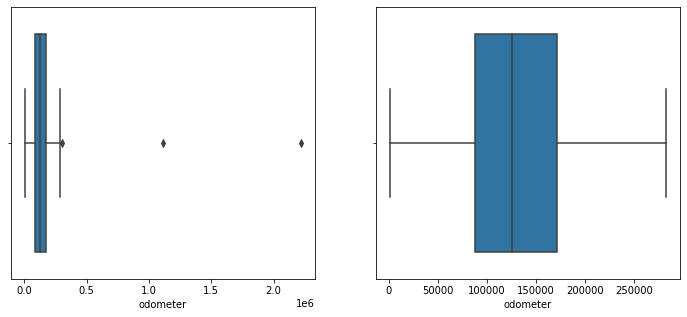

In [210]:
plt.figure(figsize=(12,5));
plt.subplot(121);
sns.boxplot(df_cleaned.odometer);

plt.subplot(122);
sns.boxplot(df_cleaned[~(df_cleaned.odometer>upper_odo)]["odometer"]);

In [211]:
df_cleaned=df_cleaned[~(df_cleaned.odometer>upper_odo)]
df_cleaned.head()

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,posting_date
31,15000,2013,ford,excellent,6 cylinders,gas,128000,clean,automatic,rwd,full-size,truck,black,al,2021-05-03T14:02:03-0500
55,19900,2004,ford,good,8 cylinders,diesel,88000,clean,automatic,4wd,full-size,pickup,blue,al,2021-04-29T17:19:18-0500
59,14000,2012,honda,excellent,6 cylinders,gas,95000,clean,automatic,fwd,full-size,mini-van,silver,al,2021-04-27T12:20:01-0500
65,22500,2001,ford,good,8 cylinders,diesel,144700,clean,manual,rwd,full-size,truck,white,al,2021-04-26T11:15:36-0500
73,15000,2017,dodge,excellent,8 cylinders,gas,90000,rebuilt,automatic,rwd,mid-size,sedan,grey,al,2021-04-24T18:39:59-0500


# Train-Test 拆分

In [212]:
X=df_cleaned.drop(columns=["price"])
y=df_cleaned["price"]
X.head()

,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,posting_date
31,2013,ford,excellent,6 cylinders,gas,128000,clean,automatic,rwd,full-size,truck,black,al,2021-05-03T14:02:03-0500
55,2004,ford,good,8 cylinders,diesel,88000,clean,automatic,4wd,full-size,pickup,blue,al,2021-04-29T17:19:18-0500
59,2012,honda,excellent,6 cylinders,gas,95000,clean,automatic,fwd,full-size,mini-van,silver,al,2021-04-27T12:20:01-0500
65,2001,ford,good,8 cylinders,diesel,144700,clean,manual,rwd,full-size,truck,white,al,2021-04-26T11:15:36-0500
73,2017,dodge,excellent,8 cylinders,gas,90000,rebuilt,automatic,rwd,mid-size,sedan,grey,al,2021-04-24T18:39:59-0500


In [213]:
y.head()

31    15000
55    19900
59    14000
65    22500
73    15000
Name: price, dtype: int64

In [254]:
X_train,X_test,y_train,y_test=train_test_split(X,y,
                                               test_size=0.20,
                                                random_state=42)

In [255]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((193, 14), (49, 14), (193,), (49,))

# 特征工程

In [256]:
multi_cat_cols = []

for col in X_train.columns:

    if X_train[col].dtypes =='O': # if variable  is categorical
    
        if X_train[col].nunique() > 10: # and has more than 10 categories
            
            multi_cat_cols.append(col)  # add to the list
            
            print(X_train.groupby(col)[col].count()/ len(X_train)) # and print the percentage of observations within each category
            
            print()

manufacturer
acura            0.010363
alfa-romeo       0.005181
audi             0.015544
bmw              0.015544
cadillac         0.005181
chevrolet        0.124352
chrysler         0.010363
dodge            0.025907
fiat             0.005181
ford             0.217617
gmc              0.036269
honda            0.062176
hyundai          0.015544
infiniti         0.015544
jaguar           0.005181
jeep             0.041451
kia              0.025907
lexus            0.020725
lincoln          0.005181
mazda            0.010363
mercedes-benz    0.036269
mini             0.010363
mitsubishi       0.025907
nissan           0.082902
ram              0.041451
saturn           0.005181
subaru           0.005181
toyota           0.093264
volkswagen       0.020725
volvo            0.005181
Name: manufacturer, dtype: float64

type
SUV            0.227979
convertible    0.036269
coupe          0.015544
hatchback      0.041451
mini-van       0.025907
offroad        0.010363
other          0.01036

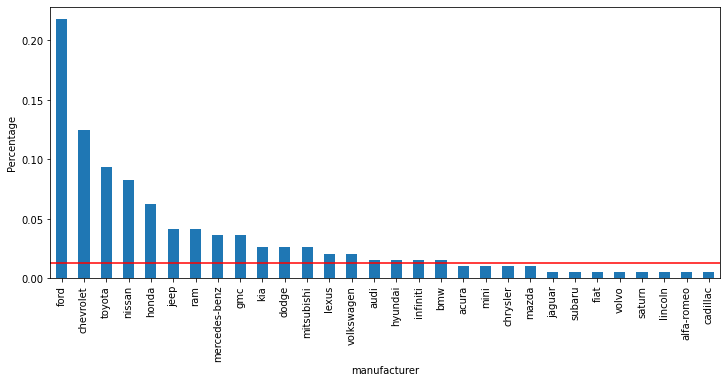

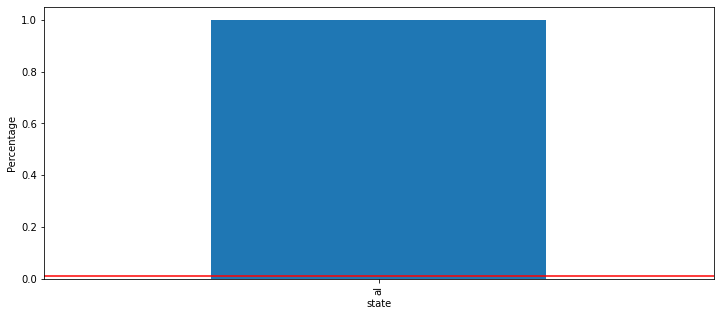

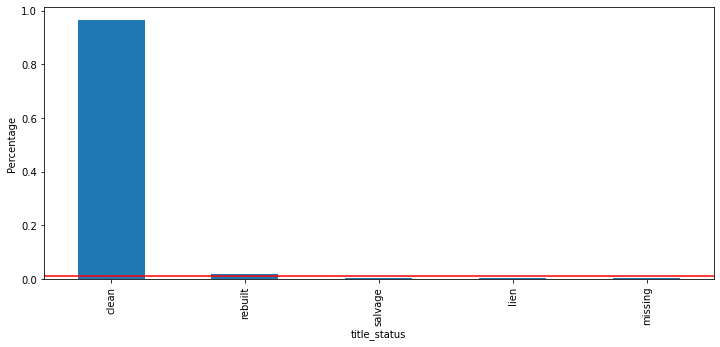

In [257]:
for col in ['manufacturer', 'state', 'title_status']:

    temp_df = pd.Series(X_train[col].value_counts() / len(X_train) )
    plt.figure(figsize=(12,5));
    # make plot with the above percentages
    fig = temp_df.sort_values(ascending=False).plot.bar()
    fig.set_xlabel(col)

    # add a line at 5 % to flag the threshold for rare categories
    fig.axhline(y=0.0125, color='red')
    fig.set_ylabel('Percentage')
    plt.show()

In [258]:
X_train.manufacturer.value_counts().to_frame()

,manufacturer
ford,42
chevrolet,24
toyota,18
nissan,16
honda,12
jeep,8
ram,8
mercedes-benz,7
gmc,7
kia,5


In [259]:
X_train.manufacturer.value_counts().index[-10:]

Index(['chrysler', 'mazda', 'subaru', 'fiat', 'volvo', 'saturn', 'lincoln',
       'alfa-romeo', 'jaguar', 'cadillac'],
      dtype='object')

In [260]:
X_train["year"]=2020-X_train["year"]
X_test["year"]=2020-X_test["year"]
X_train.head()

,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,posting_date
861,6,kia,good,4 cylinders,gas,121259,clean,automatic,fwd,compact,SUV,red,al,2021-04-23T10:33:23-0500
1479,13,lexus,good,6 cylinders,gas,181000,clean,automatic,fwd,mid-size,SUV,white,al,2021-04-10T15:49:28-0500
1190,16,nissan,good,6 cylinders,gas,200000,clean,automatic,fwd,full-size,sedan,white,al,2021-04-16T07:10:08-0500
984,16,jaguar,good,8 cylinders,gas,135185,clean,automatic,rwd,full-size,sedan,red,al,2021-04-20T13:41:00-0500
742,3,ford,excellent,6 cylinders,gas,108482,clean,automatic,rwd,full-size,van,white,al,2021-04-23T21:10:15-0500


In [261]:
rare_encoder = RareLabelCategoricalEncoder(
    tol=0.0125,  # minimal percentage to be considered non-rare
    n_categories=10, # minimal number of categories the variable should have to re-cgroup rare categories
    variables=["manufacturer","state","title_status"] # variables to re-group
)  

In [262]:
rare_encoder.fit(X_train)

RareLabelCategoricalEncoder(tol=0.0125,
                            variables=['manufacturer', 'state', 'title_status'])

In [263]:
rare_encoder.encoder_dict_

{'manufacturer': Index(['ford', 'chevrolet', 'toyota', 'nissan', 'honda', 'jeep', 'ram',
        'mercedes-benz', 'gmc', 'kia', 'dodge', 'mitsubishi', 'volkswagen',
        'lexus', 'audi', 'hyundai', 'infiniti', 'bmw'],
       dtype='object'),
 'state': array(['al'], dtype=object),
 'title_status': array(['clean', 'lien', 'rebuilt', 'salvage', 'missing'], dtype=object)}

In [264]:
X_train = rare_encoder.transform(X_train)
X_test = rare_encoder.transform(X_test)

In [265]:
rare_encoder = RareLabelCategoricalEncoder(
    tol=0.05,  # minimal percentage to be considered non-rare
    n_categories=3, # minimal number of categories the variable should have to re-cgroup rare categories
    variables=["title_status"],
    replace_with='NotClean' # variables to re-group
)  

rare_encoder.fit(X_train)
X_train = rare_encoder.transform(X_train)
X_test = rare_encoder.transform(X_test)

In [266]:
X_train.title_status.value_counts()

clean       186
NotClean      7
Name: title_status, dtype: int64

In [267]:
X_train.head()

,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,posting_date
861,6,kia,good,4 cylinders,gas,121259,clean,automatic,fwd,compact,SUV,red,al,2021-04-23T10:33:23-0500
1479,13,lexus,good,6 cylinders,gas,181000,clean,automatic,fwd,mid-size,SUV,white,al,2021-04-10T15:49:28-0500
1190,16,nissan,good,6 cylinders,gas,200000,clean,automatic,fwd,full-size,sedan,white,al,2021-04-16T07:10:08-0500
984,16,Rare,good,8 cylinders,gas,135185,clean,automatic,rwd,full-size,sedan,red,al,2021-04-20T13:41:00-0500
742,3,ford,excellent,6 cylinders,gas,108482,clean,automatic,rwd,full-size,van,white,al,2021-04-23T21:10:15-0500


In [268]:
X_train.condition.value_counts()

good         108
excellent     60
like new      17
fair           6
new            2
Name: condition, dtype: int64

In [269]:
X_train.condition=X_train.condition.replace({"salvage":1,"new":2,"fair":3,"like new":4,"good":5,"excellent":6})
X_test.condition=X_test.condition.replace({"salvage":1,"new":2,"fair":3,"like new":4,"good":5,"excellent":6})

In [273]:

X_train_encoded=pd.get_dummies(X_train,drop_first=True)
X_test_encoded=pd.get_dummies(X_test,drop_first=True)
X_train_encoded.head()

,year,condition,odometer,manufacturer_audi,manufacturer_bmw,manufacturer_chevrolet,manufacturer_dodge,manufacturer_ford,manufacturer_gmc,manufacturer_honda,manufacturer_hyundai,manufacturer_infiniti,manufacturer_jeep,manufacturer_kia,manufacturer_lexus,manufacturer_mercedes-benz,manufacturer_mitsubishi,manufacturer_nissan,manufacturer_ram,manufacturer_toyota,manufacturer_volkswagen,cylinders_3 cylinders,cylinders_4 cylinders,cylinders_5 cylinders,cylinders_6 cylinders,cylinders_8 cylinders,fuel_gas,fuel_hybrid,title_status_clean,transmission_manual,transmission_other,drive_fwd,drive_rwd,size_full-size,size_mid-size,size_sub-compact,type_convertible,type_coupe,type_hatchback,type_mini-van,type_offroad,type_other,type_pickup,type_sedan,type_truck,type_van,type_wagon,paint_color_blue,paint_color_brown,paint_color_green,paint_color_grey,paint_color_orange,paint_color_red,paint_color_silver,paint_color_white,paint_color_yellow,posting_date_2021-04-04T14:05:05-0500,posting_date_2021-04-05T12:01:06-0500,posting_date_2021-04-05T13:27:45-0500,posting_date_2021-04-05T15:12:34-0500,posting_date_2021-04-05T21:30:56-0500,posting_date_2021-04-05T22:08:06-0500,posting_date_2021-04-05T22:09:54-0500,posting_date_2021-04-06T09:56:03-0500,posting_date_2021-04-06T22:39:53-0500,posting_date_2021-04-07T09:14:55-0500,posting_date_2021-04-07T11:33:42-0500,posting_date_2021-04-07T11:36:50-0500,posting_date_2021-04-07T16:01:30-0500,posting_date_2021-04-07T19:57:06-0500,posting_date_2021-04-08T08:08:43-0500,posting_date_2021-04-08T10:08:46-0500,posting_date_2021-04-08T10:08:48-0500,posting_date_2021-04-10T13:04:35-0500,posting_date_2021-04-10T15:39:45-0500,posting_date_2021-04-10T15:49:28-0500,posting_date_2021-04-10T15:56:56-0500,posting_date_2021-04-10T15:56:59-0500,posting_date_2021-04-10T15:57:01-0500,posting_date_2021-04-10T15:57:05-0500,posting_date_2021-04-10T17:06:50-0500,posting_date_2021-04-11T10:01:18-0500,posting_date_2021-04-11T12:22:08-0500,posting_date_2021-04-11T12:23:09-0500,posting_date_2021-04-11T12:36:44-0500,posting_date_2021-04-12T09:54:43-0500,posting_date_2021-04-12T09:55:40-0500,posting_date_2021-04-12T11:14:29-0500,posting_date_2021-04-12T15:14:55-0500,posting_date_2021-04-12T15:16:06-0500,posting_date_2021-04-12T15:17:09-0500,posting_date_2021-04-12T15:42:22-0500,posting_date_2021-04-12T15:43:44-0500,posting_date_2021-04-12T19:52:25-0500,posting_date_2021-04-13T12:40:40-0500,posting_date_2021-04-13T17:05:44-0500,posting_date_2021-04-13T19:28:13-0500,posting_date_2021-04-13T19:35:25-0500,posting_date_2021-04-14T07:13:30-0500,posting_date_2021-04-14T14:59:19-0500,posting_date_2021-04-14T14:59:21-0500,posting_date_2021-04-14T16:10:16-0500,posting_date_2021-04-14T16:11:26-0500,posting_date_2021-04-14T16:11:52-0500,posting_date_2021-04-14T16:12:01-0500,posting_date_2021-04-14T16:12:37-0500,posting_date_2021-04-14T20:41:27-0500,posting_date_2021-04-14T21:42:30-0500,posting_date_2021-04-14T23:24:17-0500,posting_date_2021-04-15T01:46:43-0500,posting_date_2021-04-15T05:04:27-0500,posting_date_2021-04-15T15:12:55-0500,posting_date_2021-04-15T19:11:19-0500,posting_date_2021-04-15T19:22:40-0500,posting_date_2021-04-16T07:10:08-0500,posting_date_2021-04-16T07:12:39-0500,posting_date_2021-04-16T10:05:13-0500,posting_date_2021-04-16T12:30:15-0500,posting_date_2021-04-16T14:24:47-0500,posting_date_2021-04-16T16:49:05-0500,posting_date_2021-04-16T20:36:12-0500,posting_date_2021-04-17T15:23:27-0500,posting_date_2021-04-17T17:15:47-0500,posting_date_2021-04-17T22:01:40-0500,posting_date_2021-04-18T01:22:53-0500,posting_date_2021-04-18T09:05:45-0500,posting_date_2021-04-18T09:12:10-0500,posting_date_2021-04-18T09:23:41-0500,posting_date_2021-04-18T09:46:37-0500,posting_date_2021-04-18T13:14:47-0500,posting_date_2021-04-18T19:52:18-0500,posting_date_2021-04-18T20:35:51-0500,posting_date_2021-04-19T06:36:52-0500,posting_date_2021-04-19T19:07:56-0500,posting_date_2021-04-19T19:14:44-0500,posting_date_2021-04-20T06:34:00-0500,posting_date_2021-04-20T

# Model构建

In [234]:
y_test.mean(),y_test.std()


(12766.979591836734, 8434.529843866512)

In [235]:
preds.mean(),preds.std()

(13187.75, 7269.7446)

In [236]:
pd.DataFrame(list(zip(y_test,preds)),columns=["test","preds"]).head(10)

,test,preds
0,4000,5408.453125
1,9500,15135.587891
2,2700,5561.767578
3,5500,11785.733398
4,24500,20858.107422
5,5500,9721.025391
6,4800,5356.444336
7,13500,3743.899170
8,22950,22939.732422
9,14990,23925.353516


# 构建 Pipeline

In [239]:
X_train,X_test,y_train,y_test=train_test_split(X,y,
                                               test_size=0.20,
                                                random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((193, 14), (49, 14), (193,), (49,))

In [240]:
X_train.head()

,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,posting_date
861,2014,kia,good,4 cylinders,gas,121259,clean,automatic,fwd,compact,SUV,red,al,2021-04-23T10:33:23-0500
1479,2007,lexus,good,6 cylinders,gas,181000,clean,automatic,fwd,mid-size,SUV,white,al,2021-04-10T15:49:28-0500
1190,2004,nissan,good,6 cylinders,gas,200000,clean,automatic,fwd,full-size,sedan,white,al,2021-04-16T07:10:08-0500
984,2004,jaguar,good,8 cylinders,gas,135185,clean,automatic,rwd,full-size,sedan,red,al,2021-04-20T13:41:00-0500
742,2017,ford,excellent,6 cylinders,gas,108482,clean,automatic,rwd,full-size,van,white,al,2021-04-23T21:10:15-0500


In [241]:
X_test.head()

,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,posting_date
338,1972,mercedes-benz,fair,6 cylinders,gas,88100,clean,automatic,rwd,full-size,coupe,silver,al,2021-05-01T11:33:56-0500
110,2003,chrysler,excellent,6 cylinders,gas,30376,clean,automatic,fwd,mid-size,mini-van,blue,al,2021-04-16T10:40:58-0500
1159,2005,gmc,good,6 cylinders,gas,183876,clean,automatic,rwd,full-size,SUV,white,al,2021-04-16T16:14:08-0500
1483,2007,toyota,excellent,4 cylinders,gas,51000,clean,manual,fwd,compact,hatchback,blue,al,2021-04-10T15:11:21-0500
1945,2010,toyota,excellent,8 cylinders,gas,81100,clean,automatic,rwd,full-size,pickup,silver,al,2021-04-23T11:20:13-0500


In [242]:
X_train["year"]=2020-X_train["year"]
X_test["year"]=2020-X_test["year"]
X_train.head()

,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,posting_date
861,6,kia,good,4 cylinders,gas,121259,clean,automatic,fwd,compact,SUV,red,al,2021-04-23T10:33:23-0500
1479,13,lexus,good,6 cylinders,gas,181000,clean,automatic,fwd,mid-size,SUV,white,al,2021-04-10T15:49:28-0500
1190,16,nissan,good,6 cylinders,gas,200000,clean,automatic,fwd,full-size,sedan,white,al,2021-04-16T07:10:08-0500
984,16,jaguar,good,8 cylinders,gas,135185,clean,automatic,rwd,full-size,sedan,red,al,2021-04-20T13:41:00-0500
742,3,ford,excellent,6 cylinders,gas,108482,clean,automatic,rwd,full-size,van,white,al,2021-04-23T21:10:15-0500


In [243]:
X_test.head()

,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,posting_date
338,48,mercedes-benz,fair,6 cylinders,gas,88100,clean,automatic,rwd,full-size,coupe,silver,al,2021-05-01T11:33:56-0500
110,17,chrysler,excellent,6 cylinders,gas,30376,clean,automatic,fwd,mid-size,mini-van,blue,al,2021-04-16T10:40:58-0500
1159,15,gmc,good,6 cylinders,gas,183876,clean,automatic,rwd,full-size,SUV,white,al,2021-04-16T16:14:08-0500
1483,13,toyota,excellent,4 cylinders,gas,51000,clean,manual,fwd,compact,hatchback,blue,al,2021-04-10T15:11:21-0500
1945,10,toyota,excellent,8 cylinders,gas,81100,clean,automatic,rwd,full-size,pickup,silver,al,2021-04-23T11:20:13-0500


In [244]:
pipeline_used_car=Pipeline([
    
    ("encoder_rare_label",RareLabelCategoricalEncoder(tol=0.05,n_categories=7, variables=["manufacturer","state","title_status"])),
    
    ("encoder_rare_label_",RareLabelCategoricalEncoder(tol=0.05, n_categories=7, variables=["title_status"],replace_with='NotClean')),  
    
    ("categorical_encoder",OrdinalCategoricalEncoder(encoding_method='ordered',variables=['condition'])),
    
    ("categorical_encoder_",OneHotCategoricalEncoder(drop_last=False)),
    
    ("xgb",XGBRegressor(random_state=42))
    
    
        
])

In [245]:
pipeline=make_pipeline(RareLabelCategoricalEncoder(tol=0.05,n_categories=7, variables=["manufacturer","state","title_status"]),
                     RareLabelCategoricalEncoder(tol=0.05, n_categories=7, variables=["title_status"],replace_with='NotClean'),
                      OrdinalCategoricalEncoder(encoding_method='ordered',variables=['condition']),
                      OneHotCategoricalEncoder(drop_last=False),
                      XGBRegressor(random_state=42))

In [246]:
pipeline_used_car.fit(X_train,y_train)

Pipeline(steps=[('encoder_rare_label',
                 RareLabelCategoricalEncoder(n_categories=7,
                                             variables=['manufacturer', 'state',
                                                        'title_status'])),
                ('encoder_rare_label_',
                 RareLabelCategoricalEncoder(n_categories=7,
                                             replace_with='NotClean',
                                             variables=['title_status'])),
                ('categorical_encoder',
                 OrdinalCategoricalEncoder(variables=['condition'])),
                ('categorical_encoder_'...
                              gamma=0, gpu_id=-1, importance_type=None,
                              interaction_constraints='',
                              learning_rate=0.300000012, max_delta_step=0,
                              max_depth=6, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estim

In [247]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('rarelabelcategoricalencoder-1',
                 RareLabelCategoricalEncoder(n_categories=7,
                                             variables=['manufacturer', 'state',
                                                        'title_status'])),
                ('rarelabelcategoricalencoder-2',
                 RareLabelCategoricalEncoder(n_categories=7,
                                             replace_with='NotClean',
                                             variables=['title_status'])),
                ('ordinalcategoricalencoder',
                 OrdinalCategoricalEncoder(variables=['condition'...
                              gamma=0, gpu_id=-1, importance_type=None,
                              interaction_constraints='',
                              learning_rate=0.300000012, max_delta_step=0,
                              max_depth=6, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
      

In [248]:
preds=pipeline_used_car.predict(X_test)
r2_score(y_test,preds)

0.8117604861267627

In [249]:
predicts=pipeline.predict(X_test)
r2_score(y_test,predicts)

0.8117604861267627